L'objectif du TP est de mettre en oeuvre un algorithme Bayesien de recherche. Imaginons qu'un avion s'est écrasé en pleine mer, alors qu'il avait une trajectoire du nord vers le sud. Sa dernière position est connue et l'objectif est d'organiser les recherches afin de localiser l'épave. Nous allons pour cela utiliser les probabilités et en particulier la formule de Bayes: 
- Pour commencer nous définissons une grille de recherche (en forme de carré). 
- La première étape consiste en la définition d'une distribution à priori à partir de ce que l'on sait de la dernière position, de la trajectoire et de la vitesse de l'avion. 
- Puis grâce à un satellite, nous allons effectuer des sondages en certains points. Ces sondages nous permettrons de mettre à jour nos connaissances (à priori) en connaissance à posteriori. 

# Mise en place de la grille et représentation graphique
## Structures de données 

Commençons par mettre en place la grille de recherche et faire au passage quelques imports. La grille est centrée sur la dernière position connue. Elle aura donc comme coordonnées [0,0]. 

In [171]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from numpy import unravel_index
%matplotlib inline
%config InlineBackend.figure_formats=['svg']
%config InlineBackend.figure_format = 'svg'
delta = 10   # distance entre 2 points
dmax = 200 #  min et max pour les abscisses et ordonnées  
x = np.arange(-dmax, dmax, delta)
y = np.arange(-dmax, dmax, delta)
# l’espace de recherche est une grille 300×300 
X, Y = np.meshgrid(x, y)
XYgrid = np.c_[X.ravel(), Y.ravel()]

# color map pour les figures
my_cmap = matplotlib.cm.get_cmap('RdYlGn')

def normilize(p):
    return p / p.sum()

Regarder le type et la "shape" de X. Explorer son contenu, sachant que pour Y il s'agit de la même chose mais pour les ordonnées. Par exemple regarder les 2 premières lignes de X. 

La variable  XYgrid représente l'union de X et Y permettant d'accèder directement à chaque point (abscisse et ordonnée)  pour simplifier certains calculs. 

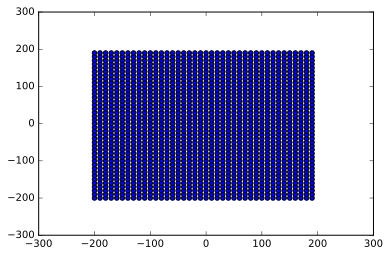

In [172]:
plt.scatter(X,Y)

## Représentation de la grille 
X et Y contiennent donc les abscisses (X) et ordonnées (Y) de chaque point de la grille. Pour représenter cette grille, il faut assigner une valeur à chaque point de la grille. Pour cela il faut créer une array numpy de même forme que X ou Y, qui contiendra chaque valeur. Commençons à afficher une distribution uniforme pour chaque point de la grille. 

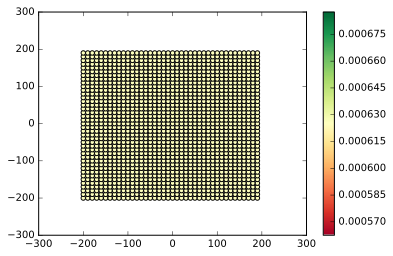

In [173]:
values = np.ones(X.shape)
values = values / values.sum()

my_cmap = matplotlib.cm.get_cmap('RdYlGn')

plt.scatter(X,Y, c=values, cmap=my_cmap)
plt.colorbar()

# Construction de l'à priori
## Vers le sud
La première chose qu'on l'on sait est que l'avion voler à priori du nord vers le sud. Définissons donc une distribution de probabilité où tous les points d'abscisse négative sont deux fois plus probables que les autres. Construire une matrice de la même dimension que X ou Y qui contient une telle distribution et représenter la graphiquement pour vérifier le résultat. La distribution sera nommé *p_southward* par la suite.  

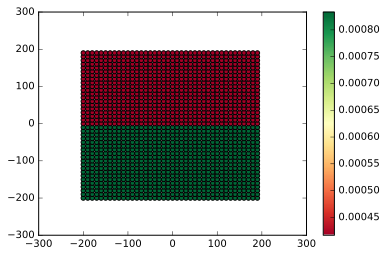

In [174]:
sud = (Y < 0) * 2.0
nord = (Y >= 0) * 1.0
p_southward = nord + sud

p_southward = p_southward / p_southward.sum()
plt.scatter(X,Y, c=p_southward, cmap=my_cmap)
plt.colorbar()

## Distance parcourue depuis la dernière position connue

Pour modéliser la distance parcourue, nous allons utiliser la loi Beta. Pour cela utilisons le code ci-dessous: 

282.842712475


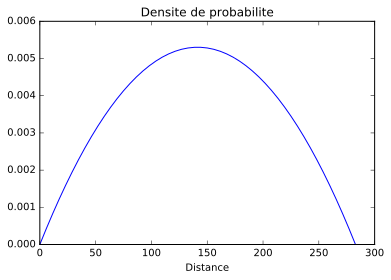

In [175]:
import scipy.stats
import math
dist_max=math.sqrt(2*(dmax**2))
print dist_max
rv = scipy.stats.beta(2, 2, loc=0, scale=dist_max)
marchDist = np.linspace(0, dist_max, 50)
pmarchDist = rv.pdf(marchDist)

plt.plot(marchDist, pmarchDist)
plt.title("Densite de probabilite")
plt.xlabel("Distance")

- Si vous modifier les deux premiers paramètres, par ex: (4,2) ou (2,4), observer les différences 

Maintenant nous allons appliquer cette densité de probabilité à la distance entre le dernier point connu (représenté par *start*) et chaque point de la grille:  écrire une fonction qui pour chaque point de la grille calcul a distance entre start et ce point. La structure à retournée doit avoir les même dimension que X ou Y. 

In [176]:
def distance(p): 
    d = np.zeros(X.shape)
    d = np.square(X-p[0])+np.square(Y-p[1])
    return np.sqrt(d)

Une fois la matrice des distances calculée, vous pouvez calculer la probabilité de ces distances avec *rv.pdf(dist)* ou dist est la matrice des distance. La distribution sera nommée *p_dist* par la suite. 
- représenter la matrice des distances
- puis la distribution de probabilité
- puis faire la même chose à partir du point (50,50) pour vérifier que cela reste cohérent. 

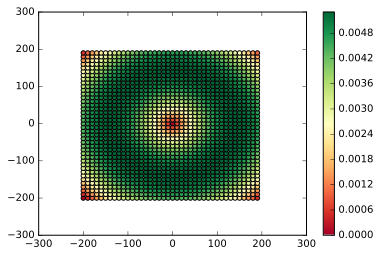

In [177]:
dist = distance ([0,0])
#plt.scatter(X,Y, c=dist, cmap=my_cmap)
#plt.colorbar()

p_dist = rv.pdf(dist)
plt.scatter(X,Y, c=p_dist, cmap=my_cmap)
plt.colorbar()

Pour la suite nous considérons l'origine comme point de référence pour calculer les distances. Donc repartons de ce point. 

## Construction  de la distribution à priori

Nous allons combiner les deux distributions: *p_dist* et *p_southward*. 
- Quelle formule appliquer pour combiner ces deux distribution ? 
- écrire le code correspondant. 
- représenter graphiquement la distribution obtenue *p_prior*.

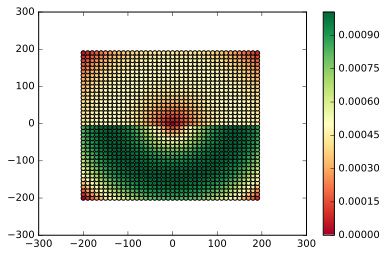

In [178]:
p_prior=p_dist * p_southward
p_prior = normilize(p_prior)
plt.scatter(X,Y, c=p_prior, cmap=my_cmap)
plt.colorbar()

# Sondage 

Le processus de recherche Bayésienne comporte 3 étapes :
- Choisir un point de l’espace de recherche — on choisit idéalement un point ayant une forte probabilité de contenir l’objet de la recherche;
- Effectuer la recherche ;
- Si la recherche échoue (c.-à-d. que l’on ne trouve pas l’objectif), mettre à jour la distribution de probabilité pour tenir compte du résultat de la recherche.

Si cette approche est très intuitive (euphémisme !), la théorie des probabilités permet, à l’aide du théorème de Bayes, d’intégrer de manière cohérente ces différentes sources d’information pour mettre à jour la distribution 
P(plane = present) en fonction des recherches effectuées. Le théorème de Bayes nous permet en effet d’écrire :


P(plane = present|sondage) ∝ P(sondage|plane = present)× P(plane = present)


La probabilité P(plane = present) correspond à l'à priori que nous venons de construire. Reste à construire la distribution P(sondage|plane = present). Cette distribution est le score de confiance que la réponse soit oui par le sondage, si l'avion est dans les parrages. 

Supposons que :
- le sondage est fiable à 99% si l'avion se situe dans la même cellule que lui (ne pas considérer que cette probabilité est de 100% permet de tenir compte du fait que le sondage peut être bruité et ne pas être dans la cellule qu’il rapporte ou tout simplement se tromper) ;
- en explorant une cellule donnée un sondage verra également ce qu’il se passe dans les cellules voisines. Évidemment,  et les chances qu’il voit l'avion diminue rapidement avec la distance. Nous supposerons que la chance de découvrir l'avions décroît de 5% tous les "kilomètres".


## Vraisemblance du sondage

- Ecrire une fonction qui prend en paramètre le point de sondage et retourne *p_dist* la distribution de probabilité que P(sondage|plane=présent). 
- prendre le point de sondange -100,-100 et représenter graphiquement le résultat. 

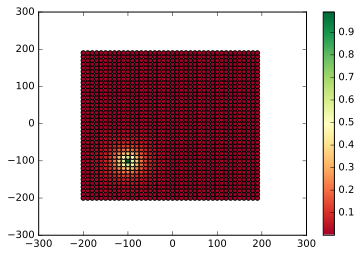

In [181]:
def sondage(p):
    z = distance(p)
    return 0.99 * 0.95 ** z

p_search = sondage([-100,-100])
plt.scatter(X,Y, c=p_search, cmap=my_cmap)
plt.colorbar()

On considère avoir trouver l'avion si  P(sondage|plane = present) > 0.95. 
- écrire une fonction qui retourne la probabilité en un point de la grille
- tester la sur le point -100,-100, vous devez obtenir 0.99
- tester également au voisinage : (-100,95), (-100,90), (-90,90)

In [153]:
def p_plan(p,p_search):
    xp = (p[0] + 200) / 10
    yp = (p[1] + 200) / 10
    return p_search[xp,yp]
print p_plan([-100,-100],p_search)

0.0100733489806


## Probabilité à posteriori

Supposons faire un sondage en (-100,-100) et qui repond que l'avion n'y est pas. 
- calculer la distribution à posteriori
- représenter la graphiquement
- commenter le résultat

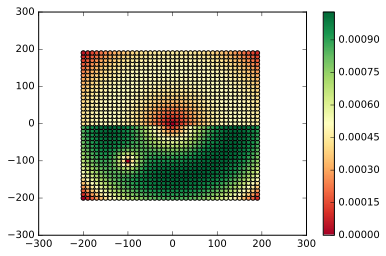

In [94]:
p_posteriori = (1-p_search) * p_prior
p_posteriori = normilize(p_posteriory)

plt.scatter(X,Y, c=p_posteriori, cmap=my_cmap)
plt.colorbar()

# Lançons les recherches

## La stratégie 
Voici l'algorithme: 
- Partons de la distribution à priori, puis choisisons un point de sondage qui maximise cette distribution. 
- si le sondage répond vrai on s'arrète, sinon:
    - calculer la distribution à posteriori
    - cette dernière devient le nouvel à priori pour la recherche suivante. 
    

Pour l'instant, nous considérons que tous les points de sondage sont infructeux. 

- Coder cette stratégie pour un nombre *nbs* de sondages. 
- Essayser avec *nbs=1* et représenter le résultat
- représenter graphiquement le résultat pour 10,20,30,50 et 100 sondages infructeux. 
- observer en particulier comment évolue la distribution de probabilité dans le nord, au fur et à mesure que le nombre de sondages infructueux augmente. 


10


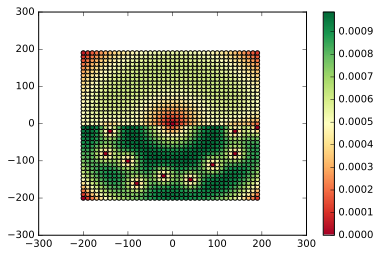

20


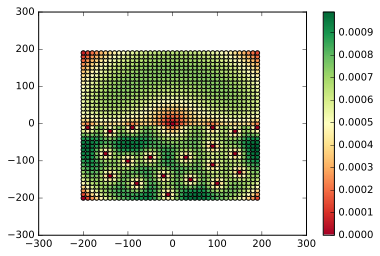

30


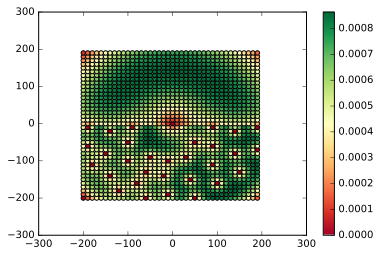

50


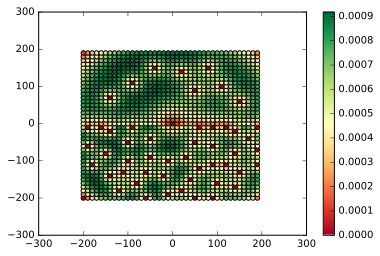

100


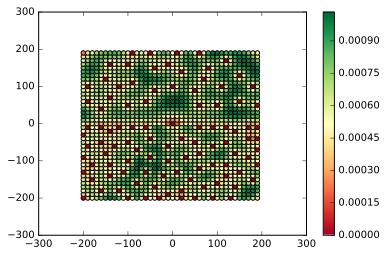

In [140]:
for j in (10,20,30,50,100):
    var_prior = p_prior.copy()
    print j
    for i in range(j):
        p_search = sondage((np.array(unravel_index(var_prior.argmax(), var_prior.shape,order='F'))*10)-200)
        p_posteriori = (1-p_search) * var_prior
        var_prior = normilize(p_posteriori)
    plt.scatter(X,Y, c=var_prior, cmap=my_cmap)
    plt.colorbar()
    plt.show()
    

## Avec plus ou moins de  chance

Le point (-10, 150) est à priori dans la zone à forte probabilité. Combien de temps met-on pour l'atteindre ? 
Pour cela écrire l'algorithme de recherche et compter le nombre de sondage avant d'arriver à trouver l'avion. Comparer ce résultat avec une recherche aléatoire. 

Puis essayer avec les points (10,150), (190,190), (0,200)

187 [-10, 150]


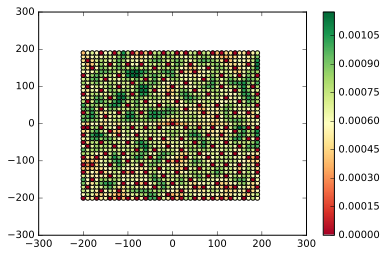

990 [10, 150]


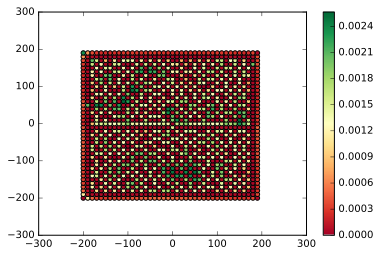

In [169]:
planes = ([-10,150],[10,150])#,[190,190],[0,199])
for plane in planes:
    i = 0
    var_prior = p_prior.copy()
    while (True):
            i = i + 1
            p_search = sondage((np.array(unravel_index(var_prior.argmax(), var_prior.shape,order='F'))*10)-200)
            if p_plan(plane,p_search) >= 0.95:
                break
            p_posteriori = (1-p_search) * var_prior
            var_prior = normilize(p_posteriori)
    print i, plane
    plt.scatter(X,Y, c=var_prior, cmap=my_cmap)
    plt.colorbar()
    plt.show()

## Avec des meilleurs sondages

Supposons que la chance de découvrir l'avion décroit que de 2% par "kilomètre". Relancer les expériences et comparer le nombre d'itération. 

545 [-10, 150]


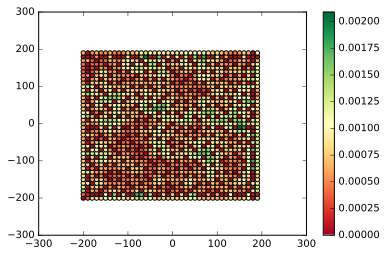

1624 [10, 150]


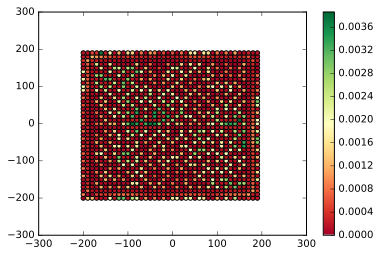

In [182]:
def sondage1(p):
    z = distance(p)
    return 0.99 * 0.98 ** z
for plane in planes:
    i = 0
    var_prior = p_prior.copy()
    while (True):
            i = i + 1
            p_search = sondage1((np.array(unravel_index(var_prior.argmax(), var_prior.shape,order='F'))*10)-200)
            if p_plan(plane,p_search) >= 0.95:
                break
            p_posteriori = (1-p_search) * var_prior
            var_prior = normilize(p_posteriori)
    print i, plane
    plt.scatter(X,Y, c=var_prior, cmap=my_cmap)
    plt.colorbar()
    plt.show()